In [1]:
import numpy as np
import psi4
from psi4.driver.procrouting.response.scf_response import tdscf_excitations
import matplotlib.pyplot as plt

In [2]:
#set output file
psi4.set_output_file("HF_output.txt", False)
#molecule geometry
mol = psi4.geometry("""
0 1
F 0.0 0.0 0.0
H 0.9 0.0 0.0
""")

hartree_to_inver_cm = 219474.6 #one hartree is equal to 219474.6 cm^-1
amu_to_au = 1822.89 #atomic mass units to atomic units of mass

H_m = 1.00784 * amu_to_au #mass of hydrogen in au
F_m = 18.9984 * amu_to_au #mass of fluorine in au

mu = H_m * F_m / (H_m + F_m) #reduced mass of HF, au

#save_jk file
#use cc-pVDZ basis
psi4.set_options({'save_jk': True, 'basis': 'cc-pVDZ', 'reference': 'rhf'})

#optimize geometry
psi4.optimize('b3lyp/cc-pVDZ',molecule=mol)

#store optimal geometry
geom_bohr = np.array(mol.geometry()) #geometry in bohr
geom_ang = geom_bohr * psi4.constants.bohr2angstroms #geometry in angstrom

#calculate equilibrium bond lenght
#psi4.optimize rotates diatomics to align with the z-axis
fz = geom_ang[0].tolist()[2] #z coordinate of fluorine
hz = geom_ang[1].tolist()[2] #z coordinate of hydrogen
bond_len_eq = hz - fz  #bond length, angstroms
 
#calculat ground state energy and wavefunction
e, wfn = psi4.energy("b3lyp/cc-pVDZ", return_wfn=True, molecule=mol)

#calculate excited state energy
res = tdscf_excitations(wfn, states=2, triplets = "NONE")
excited_state_1 = e + res[0]['EXCITATION ENERGY']

print(f"Ground state energy: {e} Hartrees")
print(f"Excited state energy: {excited_state_1} Hartrees")
print(f"Equilibrium bond length: {bond_len_eq} Angstroms")

Optimizer: Optimization complete!
Ground state energy: -100.43557891730518 Hartrees
Excited state energy: -99.90357778925836 Hartrees
Equilibrium bond length: 0.926704041193929 Angstroms


In [3]:
#change reference to uhf
psi4.set_options({'reference': 'uhf'})

#fluorine geometry
fluorine = psi4.geometry("""
0 2
F
""")
#calculate energy of fluorine
e_f = psi4.energy("b3lyp/cc-pVDZ", molecule=fluorine)

#hydrogen geometry
hydrogen = psi4.geometry("""
0 2
H
""")
#calculate energy of hydrogen
e_h = psi4.energy("b3lyp/cc-pVDZ", molecule=hydrogen)

#calculate dissociation energy (energy of fluorine + energy of hydrogen - energy of HF)
De_psi4 = e_f + e_h - e #dissociation energy in hartrees

In [4]:
De_eV = De_psi4 * 27.211 #dissociation energy in eV
De_eV

5.651551598961011

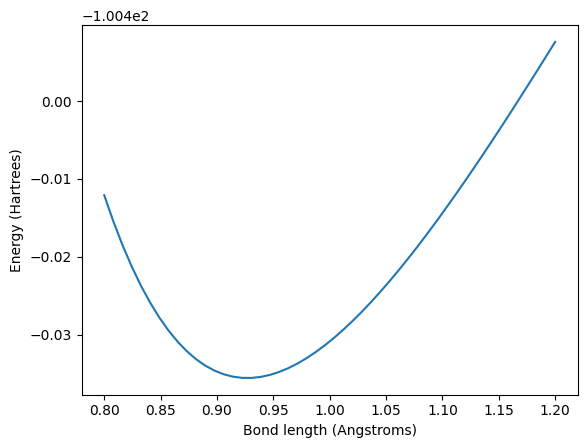

In [4]:
#creating energy potential curve
hx = np.linspace(0.8, 1.2, 50)

energy_dict = {}

psi4.set_options({'save_jk': True, 'basis': 'cc-pVDZ', 'reference': 'rhf'})

for i in hx:
    #set geometry
    temp_mol = psi4.geometry(f"""
    F 0.0 0.0 0.0
    H {i} 0.0 0.0
    """)

    #calculate energy and store in energy_dict
    test_e = psi4.energy("b3lyp/cc-pVDZ", molecule=temp_mol)
    energy_dict[i] = test_e

#potential energy curve
plt.plot(list(energy_dict.keys()), list(energy_dict.values()))
plt.xlabel('Bond length (Angstroms)')
plt.ylabel('Energy (Hartrees)')
plt.show()

In [6]:
#finite differences to calculate second derivative

psi4.set_options({'save_jk': True, 'basis': 'cc-pVDZ', 'reference': 'rhf'})

h = 0.001
low_val = bond_len_eq - h #req - h
high_val = bond_len_eq + h #req + h

#lists to store lengths and energies
len_list = [low_val, bond_len_eq, high_val]
e_list = []

#loop to get energy value at different lengths
for i in len_list:
    #set geometry
    temp_mol = psi4.geometry(f"""
    F 0.0 0.0 0.0
    H {i} 0.0 0.0
    """)

    temp_e = psi4.energy("b3lyp/cc-pVDZ", molecule=temp_mol)
    e_list.append(temp_e)

#calculate force constant using finite differences
k = (e_list[2] - 2 * e_list[1] +  e_list[0])/ (h / psi4.constants.bohr2angstroms) ** 2 #force constant, hartrees per bohr^2

print(k)

0.5865548436859783


In [7]:
#finite differences to calculate g

psi4.set_options({'save_jk': True, 'basis': 'cc-pVDZ', 'reference': 'rhf'})

h = 0.001
low_val1 = bond_len_eq - h #req - h
low_val2 = bond_len_eq - 2 * h #req - 2h
high_val1 = bond_len_eq + h #req + h
high_val2 = bond_len_eq + 2 * h #req + 2h

#lists to store lengths and energies
len_list = [low_val2, low_val1, high_val1, high_val2]
e_list = []

#loop to get energy value at different lengths
for i in len_list:
    #set geometry
    temp_mol = psi4.geometry(f"""
    F 0.0 0.0 0.0
    H {i} 0.0 0.0
    """)

    temp_e = psi4.energy("b3lyp/cc-pVDZ", molecule=temp_mol)
    e_list.append(temp_e)

#calculate force constant using finite differences
g = (e_list[3] - 2 * e_list[2] + 2 * e_list[1] -  e_list[0])/ (2 * (h / psi4.constants.bohr2angstroms) ** 3) #force constant, hartrees per bohr^2

print(g)

-2.287508848506965


In [8]:
#finite differences to calculate g

psi4.set_options({'save_jk': True, 'basis': 'cc-pVDZ', 'reference': 'rhf'})

h = 0.001
low_val1 = bond_len_eq - h #req - h
low_val2 = bond_len_eq - 2 * h #req - 2h
high_val1 = bond_len_eq + h #req + h
high_val2 = bond_len_eq + 2 * h #req + 2h

#lists to store lengths and energies
len_list = [low_val2, low_val1, bond_len_eq, high_val1, high_val2]
e_list = []

#loop to get energy value at different lengths
for i in len_list:
    #set geometry
    temp_mol = psi4.geometry(f"""
    F 0.0 0.0 0.0
    H {i} 0.0 0.0
    """)

    temp_e = psi4.energy("b3lyp/cc-pVDZ", molecule=temp_mol)
    e_list.append(temp_e)

#calculate force constant using finite differences
#force constant, hartrees per bohr^2
h = (e_list[4] - 4 * e_list[3] + 6 * e_list[2] - 4 * e_list[1] +  e_list[0])/ (h / psi4.constants.bohr2angstroms) ** 4
print(h)

7.223268477966221


In [9]:
beta = -g / ( 3 * k)
De = k / (2 * beta ** 2)
print(beta)
print(De)

w = np.sqrt(k / mu) #omega in hartrees
xe = w / (4 * De) #xe in hartrees
w_xe = w * xe #omega_xe in hartrees

print(w)
print(w_xe)

#conversion of omega and omega_xe to cm^-1 for comparison with experimental data
w_inver_cm = w *  hartree_to_inver_cm
w_xe_inver_cm = w_xe * hartree_to_inver_cm
print(w_inver_cm)
print(w_xe_inver_cm)

1.299968720249014
0.1735452873680237
0.018335911729858174
0.00048431977621522207
4024.2668925459307
106.29588915692538


In [ ]:
D

In [11]:
def evaluate_Morse(r, De, beta, r_eq, g, h):
    V_M = De * (1 - np.e ** (-beta * (r - r_eq))) ** 2 #+ 1/6 * g * (r - r_eq) ** 3 + 1/24 * h * (r - r_eq) ** 4
    return V_M

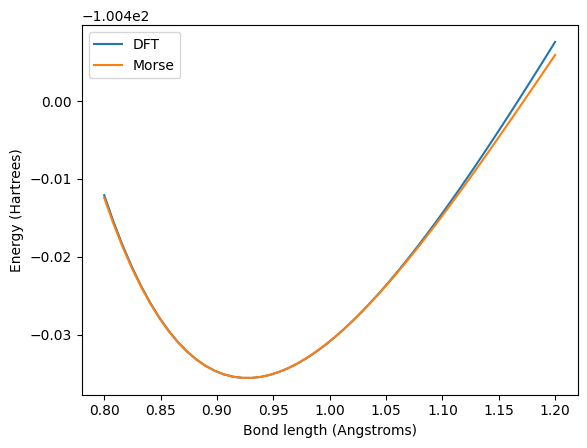

In [12]:
morse_dict = {}
for i in hx:
    temp_e = float(evaluate_Morse((i / psi4.constants.bohr2angstroms), De, beta, (bond_len_eq / psi4.constants.bohr2angstroms), g, h) + e)
    morse_dict[i] = temp_e

plt.plot(list(energy_dict.keys()), list(energy_dict.values()), label='DFT')
plt.plot(list(morse_dict.keys()), list(morse_dict.values()), label='Morse')
plt.xlabel('Bond length (Angstroms)')
plt.ylabel('Energy (Hartrees)')
plt.legend()
plt.show()

In [13]:
excited_state_1 = e + res[0]['EXCITATION ENERGY']
excited_state_2 = e + res[1]['EXCITATION ENERGY']

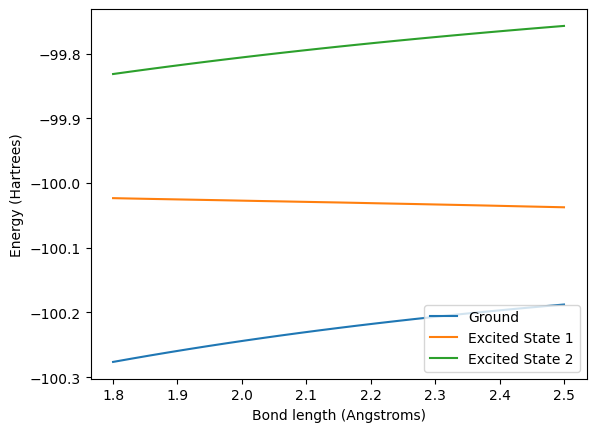

In [30]:
#creating energy potential curve
hx = np.linspace(0.8, 3.0, 50)

test_dict = {}
e1_dict = {}
e2_dict = {}
excitation_1 = {}
excitation_2 = {}

eg = []
e1 = []
e2 = []
psi4.set_options({'save_jk': True, 'basis': 'cc-pVDZ', 'reference': 'rhf',})

for i in hx:
    #set geometry
    temp_mol = psi4.geometry(f"""
    F 0.0 0.0 0.0
    H {i} 0.0 0.0
    """)

    #calculate energy and store in energy_dict
    test_e, test_wfn = psi4.energy("wb97x-d/cc-pVDZ",return_wfn=True, molecule=temp_mol)
    test_res = tdscf_excitations(test_wfn, states=3, triplets = "NONE")

    test_dict[i] = test_e
    e1_dict[i] = test_res[0]['EXCITATION ENERGY'] + test_e
    e2_dict[i] = test_res[1]['EXCITATION ENERGY'] + test_e

    excitation_1[i] = test_res[0]['EXCITATION ENERGY']
    excitation_2[i] = test_res[1]['EXCITATION ENERGY']

#potential energy curve
plt.plot(list(test_dict.keys()), list(test_dict.values()),label='Ground')
plt.plot(list(e1_dict.keys()), list(e1_dict.values()),label='Excited State 1')
plt.plot(list(e2_dict.keys()), list(e2_dict.values()),label='Excited State 2')
plt.xlabel('Bond length (Angstroms)')
plt.ylabel('Energy (Hartrees)')
plt.legend()
plt.show()

In [26]:
#optimize excited state geometry

psi4.set_options({'save_jk': True, 'basis': 'aug-cc-pVTZ', 'reference': 'rhf'})

optimized = False
forward = True
past = 0
current = 0
iterate = 0.01
i = 1.0
while optimized == False:
    i
    test_mol = psi4.geometry(f"""
    0 1
    F 0.0 0.0 0.0
    H {i} 0.0 0.0
    """)

    #calculate excited energy
    temp_e, temp_wfn = psi4.energy("wb97x-d/aug-cc-pVTZ", return_wfn= True, molecule=test_mol)
    temp_res = tdscf_excitations(temp_wfn, states=2, triplets = "NONE")
    current = temp_e + temp_res[1]['EXCITATION ENERGY']
    print(i)

    #if abs(current - past) < 0.0000005 -> optimized = True
    #break
    if (abs(current - past) < 0.0000005):
        optimized = True
        break
    #if current < past -> past = current
    #iterate to next geometry
    if (current < past):
        past = current
        i += iterate

    #if current > past -> past = current
    #iterate = iterate / -2 bond length decreases
    #iterate to next geomtry
    if (current > past):
        past = current
        iterate = iterate / -2
        i += iterate

print(i)

1.0
1.01
1.0050000000000001
1.0000000000000002
0.9950000000000002
0.9900000000000002
0.9850000000000002
0.9800000000000002
0.9750000000000002
0.9700000000000002
0.9650000000000002
0.9600000000000002
0.9625000000000001
0.9650000000000001
0.9675
0.96625
0.9650000000000001
0.9650000000000001


In [16]:
opt_ex_geom = i

In [31]:
import numpy as np
import psi4
from psi4.driver.procrouting.response.scf_response import tdscf_excitations
import matplotlib.pyplot as plt

r_list = np.linspace(0.5, 2.1, 100)
eg = np.zeros_like(r_list)
e1 = np.zeros_like(r_list)
e2 = np.zeros_like(r_list)
e3 = np.zeros_like(r_list)

ctr = 0
for r in r_list:
    #set geometry
    hf_str = f"""
    F 0.0 0.0 0.0
    H {r} 0.0 0.0
    """
    
    temp_mol = psi4.geometry(hf_str)
    
    #calculate energy and store in energy_dict
    test_e, test_wfn = psi4.energy("wb97x-d/cc-pVDZ",return_wfn=True, molecule=temp_mol)
    test_res = tdscf_excitations(test_wfn, states=3, triplets = "NONE")

    eg[ctr] = test_e
    e1[ctr] = test_e + test_res[0]['EXCITATION ENERGY']
    e2[ctr] = test_e + test_res[1]['EXCITATION ENERGY']
    e3[ctr] = test_e + test_res[2]['EXCITATION ENERGY']

    ctr+=1





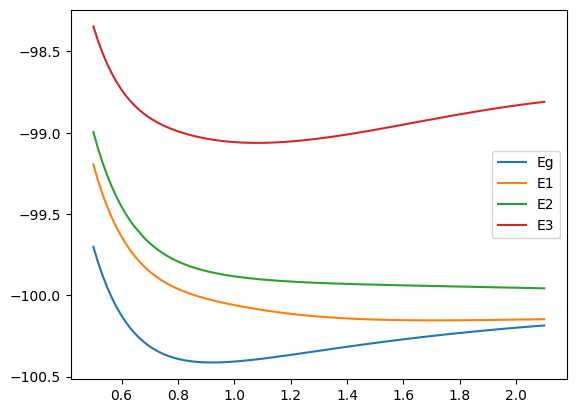

In [32]:
plt.plot(r_list, eg, label="Eg")
plt.plot(r_list, e1, label="E1")
plt.plot(r_list, e2, label="E2")
plt.plot(r_list, e3, label="E3")
plt.legend()
plt.show()

In [24]:
mol = psi4.geometry(hf_str)
test_e, test_wfn = psi4.energy("wb97x-d/cc-pVDZ",return_wfn=True, molecule=mol)
test_res = tdscf_excitations(test_wfn, states=3, triplets = "NONE")

In [30]:
print(test_res[2]['EXCITATION ENERGY'])

1.3754534023334388
